<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [2] used 0.0664 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 120.25 MiB


Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 3min 21s
In [2] used 1808.9375 MiB RAM in 202.03s, peaked 1891.17 MiB above current, total RAM usage 1928.75 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

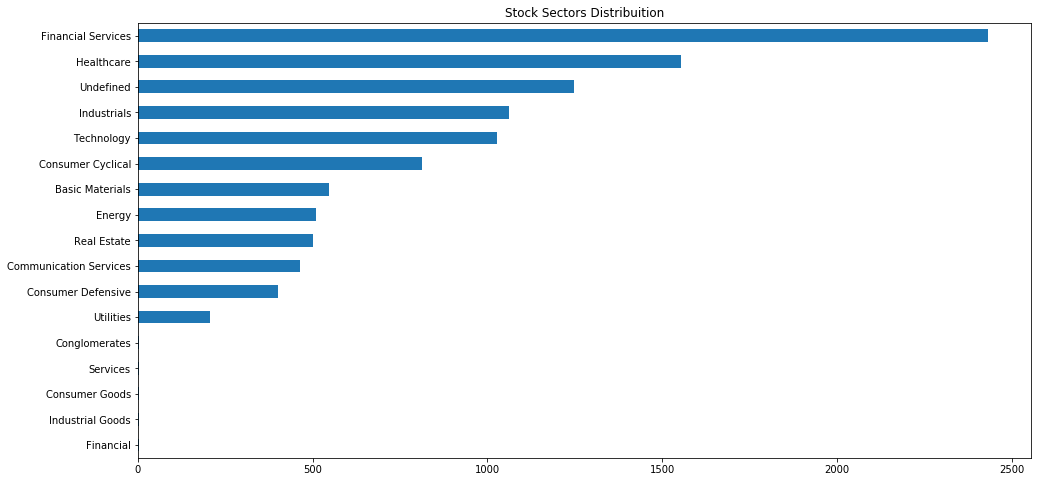

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [3]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [3] used 7.3594 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 1936.11 MiB


Чищу данные.

In [4]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 1min 6s
In [4] used -1488.4766 MiB RAM in 67.03s, peaked 3993.27 MiB above current, total RAM usage 447.63 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [15]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [5]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 9min 9s
In [5] used -20.6875 MiB RAM in 549.37s, peaked 1250.04 MiB above current, total RAM usage 426.94 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [17]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.392% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [6]:
%%time

not_in_df = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                .isna().unstack().reset_index(name='nid')

not_in_df = not_in_df[not_in_df.nid]

df = df.merge(not_in_df, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

Wall time: 2min 8s
In [6] used 1180.6367 MiB RAM in 128.21s, peaked 2040.94 MiB above current, total RAM usage 1607.58 MiB


In [7]:
%%time

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 15.5 s
In [7] used 455.9688 MiB RAM in 15.68s, peaked 1360.65 MiB above current, total RAM usage 2063.55 MiB


In [8]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

In [8] used 997.9297 MiB RAM in 1.12s, peaked 0.00 MiB above current, total RAM usage 3061.48 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [9]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [9] used 4.0625 MiB RAM in 1.36s, peaked 474.73 MiB above current, total RAM usage 3065.54 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [10]:
funds_value.head()

,period,cik,market_value
9,2015Q3,11544,575410000.0
460,2015Q3,1011443,988635000.0
759,2015Q3,1098490,323808000.0
892,2015Q3,1140042,33757000.0
1156,2015Q3,1288136,68613000.0


In [10] used 2.3672 MiB RAM in 0.18s, peaked 0.00 MiB above current, total RAM usage 3067.91 MiB


In [11]:
high_value = np.quantile(funds_value.market_value, 2/3)
low_value = np.quantile(funds_value.market_value, 1/3)

high_value, low_value

(372683000.0, 88283000.0)

In [11] used 0.1289 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3068.04 MiB


Рассмотрим некоторые основные описательные статистики.

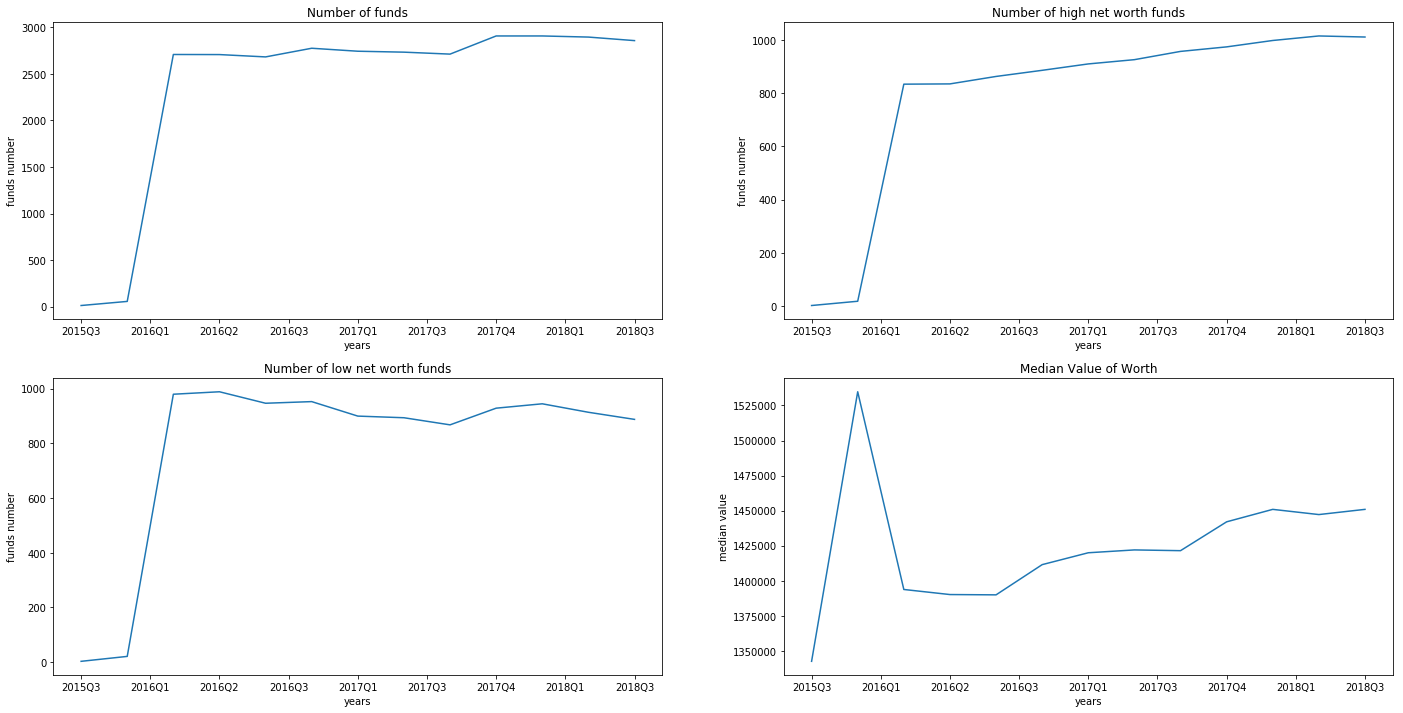

In [12] used 13.0469 MiB RAM in 1.57s, peaked 5.58 MiB above current, total RAM usage 3081.08 MiB


In [12]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [13]:
final_df = final_df[final_df.period >= '2016Q1']

In [13] used -201.9688 MiB RAM in 3.29s, peaked 1084.73 MiB above current, total RAM usage 2879.11 MiB


Теперь я посмотрю на распределение ценности фондов.

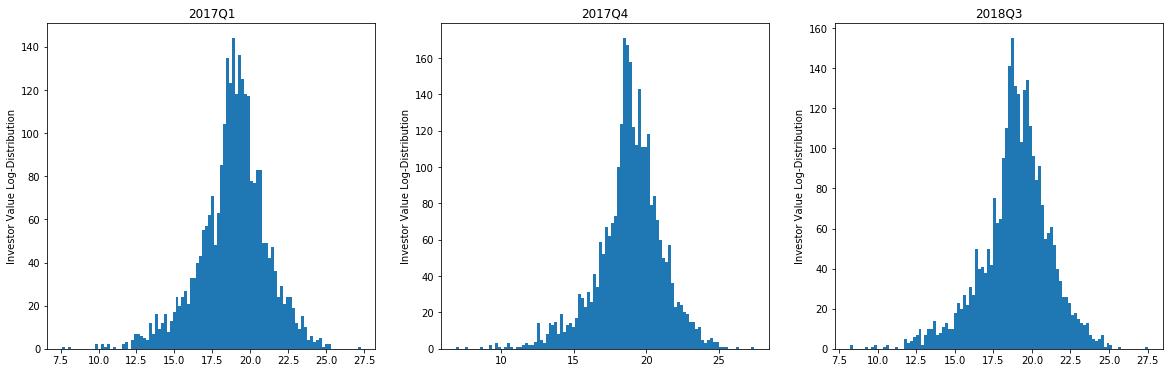

In [14] used 21.5625 MiB RAM in 1.39s, peaked 1.96 MiB above current, total RAM usage 2900.68 MiB


In [14]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [15]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.cut(final_df.market_value_fund, [0, low_value, high_value, final_df.market_value_fund.max()],
                              labels=['low', 'med', 'high'])

In [15] used -299.6797 MiB RAM in 9.58s, peaked 1608.25 MiB above current, total RAM usage 2601.00 MiB


In [16]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [16] used -174.5586 MiB RAM in 10.90s, peaked 1158.07 MiB above current, total RAM usage 2426.44 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [17]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 23.3 s
In [17] used 1512.3477 MiB RAM in 23.38s, peaked 239.65 MiB above current, total RAM usage 3938.79 MiB


## Создание зависимой переменной

In [18]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [18] used 110.5273 MiB RAM in 2.35s, peaked 5.08 MiB above current, total RAM usage 4049.31 MiB


In [19]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [19] used -1201.0977 MiB RAM in 27.20s, peaked 1644.68 MiB above current, total RAM usage 2848.21 MiB


In [117]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 951 ms
In [117] used 232.3711 MiB RAM in 1.06s, peaked 1.30 MiB above current, total RAM usage 1495.25 MiB


But at what cost?

In [29]:
final_df[final_df.net_changes < -1].net_changes

2037152   -1.0
3227948   -1.0
3657031   -1.0
6548269   -1.0
7206569   -1.0
7214567   -1.0
7525270   -1.0
Name: net_changes, dtype: float64

In [29] used -121.9961 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 956.02 MiB


In [22]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(20)

,cik,period,ticker_id,shares,market_value,close,mode_close
450,1641866,2018Q3,779,66.0,2000.0,30.303030,37.729506
1941,1641866,2016Q1,780,62.0,1000.0,16.129032,23.270035
1942,1641866,2016Q2,780,62.0,1000.0,16.129032,23.339991
2594,1423442,2016Q4,784,115212.0,3411000.0,29.606291,21.069145
4169,1588539,2018Q2,829,72.0,1000.0,13.888889,22.590271
4170,1588539,2018Q3,829,72.0,1000.0,13.888889,21.470913
4386,1732854,2017Q4,829,224.0,35000.0,156.250000,23.087181
4655,884423,2016Q3,835,11.0,1000.0,90.909091,9.637694
5079,1134008,2017Q2,835,47.0,1000.0,21.276596,11.644962
5194,1209324,2018Q3,835,47.0,1000.0,21.276596,11.300867


In [22] used 1676.9141 MiB RAM in 2.31s, peaked 21.58 MiB above current, total RAM usage 3620.07 MiB


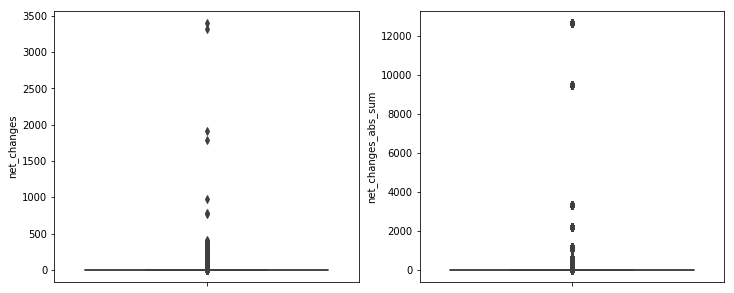

In [23] used 275.1641 MiB RAM in 16.21s, peaked 95.56 MiB above current, total RAM usage 3895.23 MiB


In [23]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

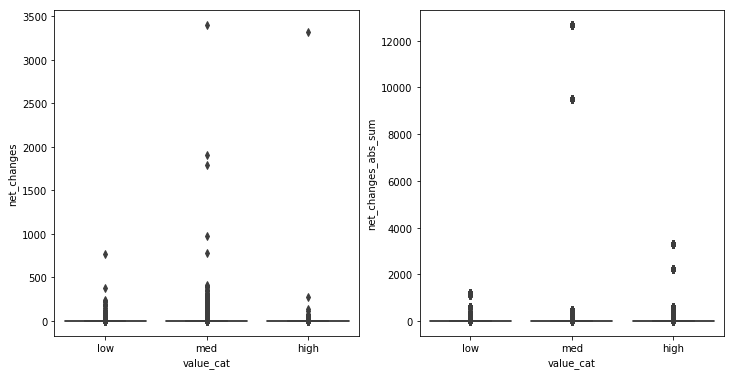

In [24] used 224.4414 MiB RAM in 16.55s, peaked 144.59 MiB above current, total RAM usage 4119.68 MiB


In [24]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

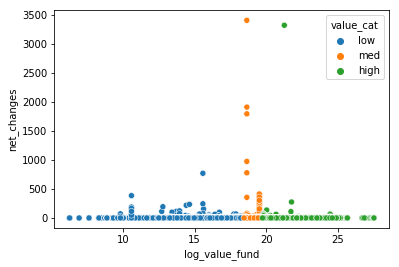

In [25] used -1138.3906 MiB RAM in 483.93s, peaked 2271.44 MiB above current, total RAM usage 2981.29 MiB


In [25]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

<b> Остановился ТУТ!!!

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

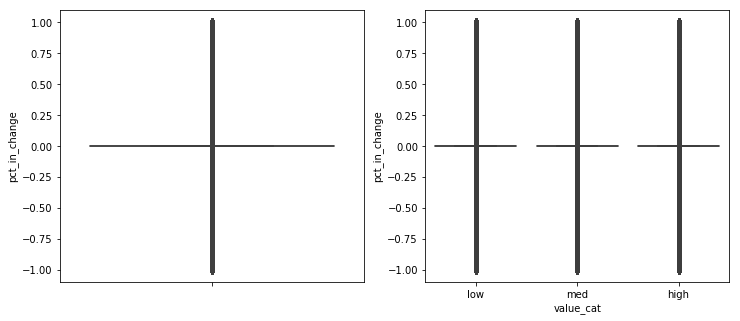

In [26] used 292.7695 MiB RAM in 32.13s, peaked 192.15 MiB above current, total RAM usage 3274.05 MiB


In [26]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

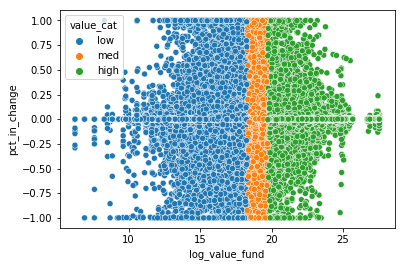

In [27] used -944.4141 MiB RAM in 744.27s, peaked 2239.68 MiB above current, total RAM usage 2329.64 MiB


In [27]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [36]:
final_df['ticker_share_lag_1'] = final_df.ticker_share.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['ticker_share_lag_2'] = final_df.ticker_share.shift(periods=2). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=2) == 2))

final_df['ticker_share_lag_4'] = final_df.ticker_share.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

In [36] used -480.7188 MiB RAM in 13.07s, peaked 514.44 MiB above current, total RAM usage 2951.43 MiB


Отлично, у меня теперь MemoryError. Что же придется, уменьшить выборку.

In [3]:
final_df = final_df[final_df.cik.isin(np.random.choice(final_df.cik.unique(), 1000, replace=False))]

In [3] used -408.1875 MiB RAM in 76.24s, peaked 2510.90 MiB above current, total RAM usage 1699.61 MiB


In [20]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
1197,2016Q2,1466153,1.174307
522,2016Q1,1534417,NaN
6032,2017Q4,1664214,NaN
1283,2016Q2,1534522,0.104916
7799,2018Q3,873687,0.000000


In [20] used 192.3477 MiB RAM in 31.71s, peaked 1089.93 MiB above current, total RAM usage 2267.85 MiB


In [21]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
5197,2017Q3,1630888,NaN
8232,2018Q3,1532520,0.000000
6607,2018Q1,1512611,0.381050
4013,2017Q2,1163653,1.585397
1484,2016Q2,1656456,NaN


In [21] used 5.8555 MiB RAM in 22.23s, peaked 1736.70 MiB above current, total RAM usage 2273.71 MiB


In [22]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
7748,2018Q3,61227,0.137422
705,2016Q1,1641866,NaN
8010,2018Q3,1291422,NaN
5011,2017Q3,1504744,0.523683
3973,2017Q2,1102578,2.000000


In [22] used -0.2891 MiB RAM in 19.45s, peaked 1736.65 MiB above current, total RAM usage 2273.42 MiB


Теперь HHI.

In [23]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,9631,0.082798
1,2016Q1,10742,0.019137
2,2016Q1,14661,0.048942
3,2016Q1,35442,0.140649
4,2016Q1,61227,0.140265


In [23] used -27.1406 MiB RAM in 17.22s, peaked 1764.60 MiB above current, total RAM usage 2246.28 MiB


Теперь посмотрю на их распределение.

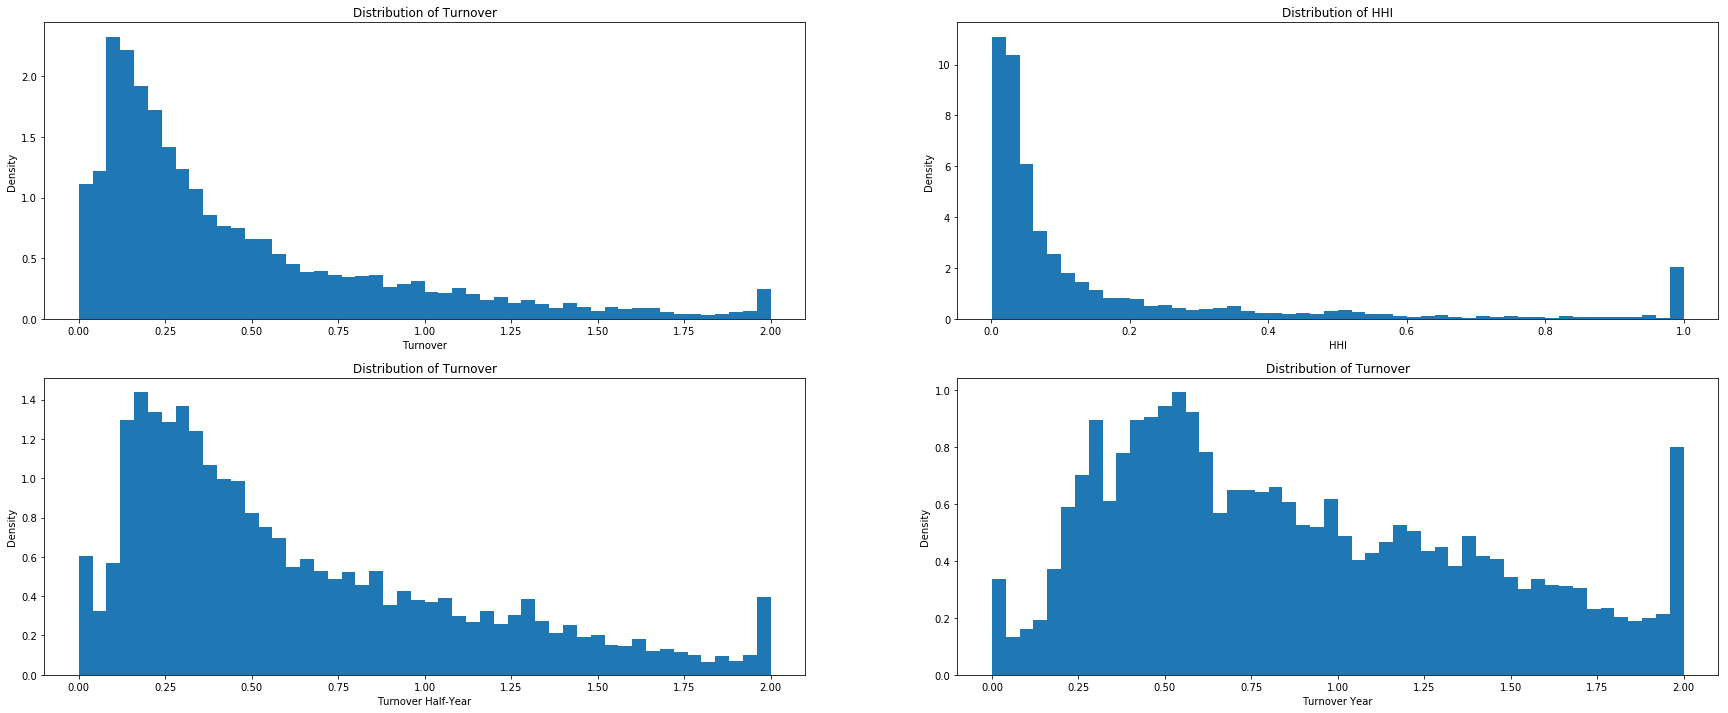

In [27] used 8.6836 MiB RAM in 1.49s, peaked 6.86 MiB above current, total RAM usage 1573.28 MiB


In [27]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

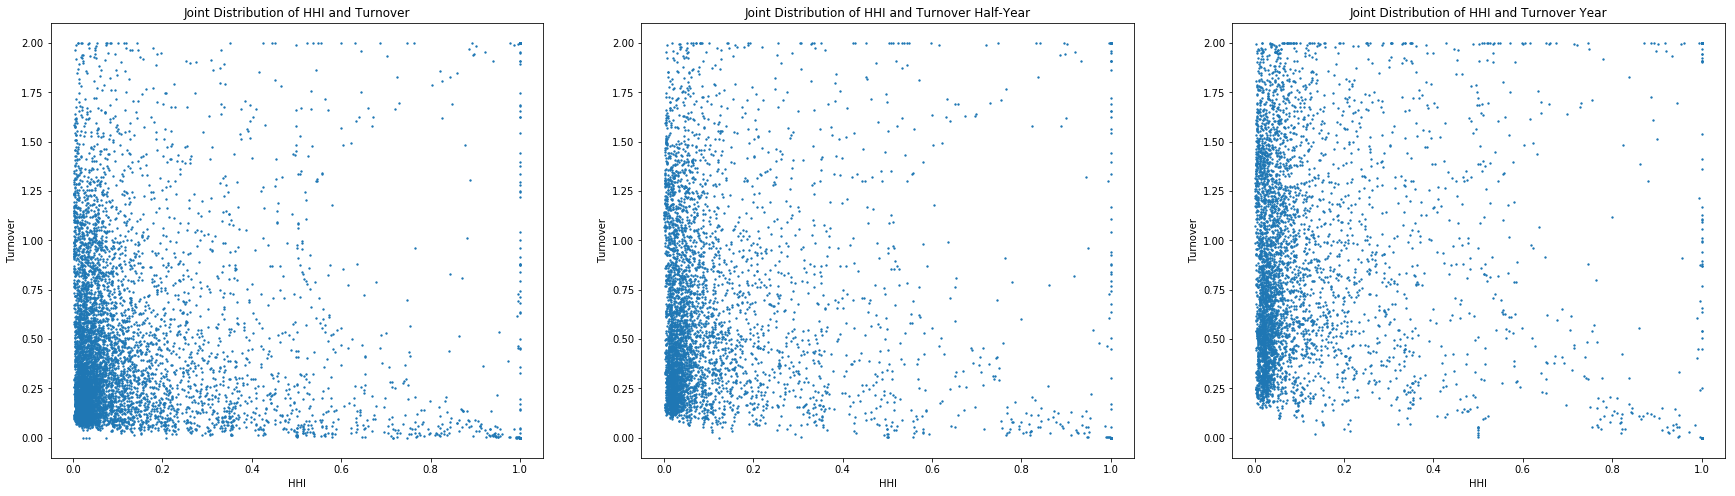

In [33] used -13.9180 MiB RAM in 0.76s, peaked 3.88 MiB above current, total RAM usage 1568.98 MiB


In [33]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [34]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [34] used 1360.6836 MiB RAM in 30.36s, peaked 911.55 MiB above current, total RAM usage 2929.66 MiB


In [35]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, 0), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, 0), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, 0),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, 0),
                                                                                                labels=np.arange(10))

In [35] used 19.0547 MiB RAM in 0.79s, peaked 11.80 MiB above current, total RAM usage 2948.71 MiB


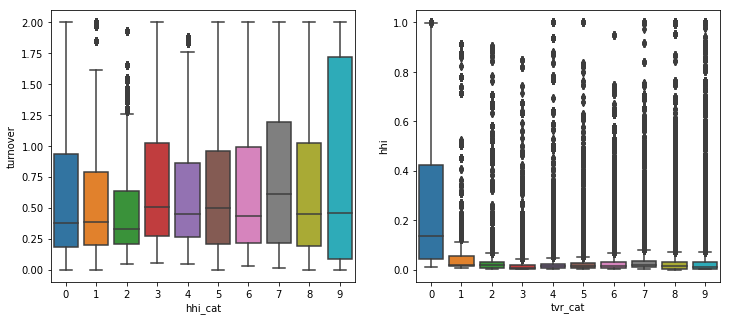

In [36] used -497.9609 MiB RAM in 4.82s, peaked 556.84 MiB above current, total RAM usage 2450.75 MiB


In [36]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

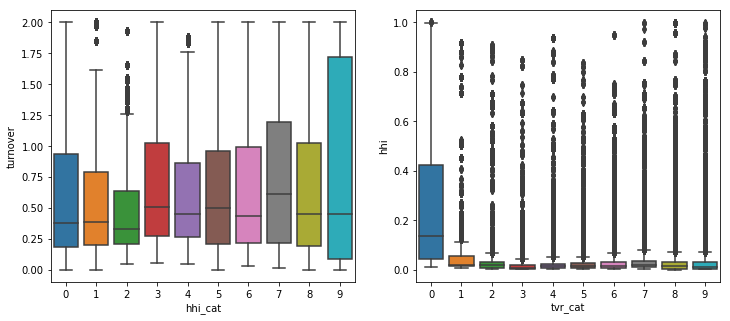

In [37] used 904.6172 MiB RAM in 9.97s, peaked 170.11 MiB above current, total RAM usage 3355.37 MiB


In [37]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

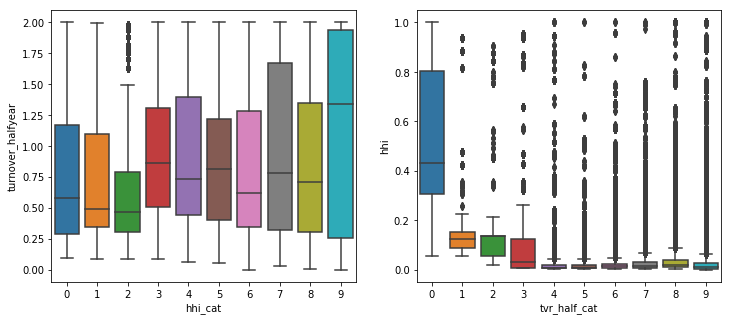

In [40] used 12.2148 MiB RAM in 1.72s, peaked 48.86 MiB above current, total RAM usage 2416.64 MiB


In [40]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

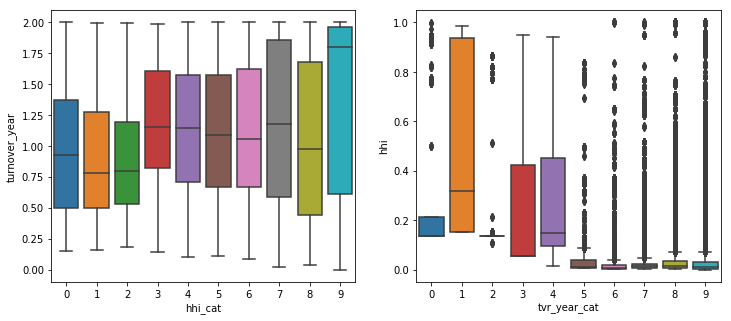

In [41] used 11.4375 MiB RAM in 1.69s, peaked 50.44 MiB above current, total RAM usage 2428.08 MiB


In [41]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

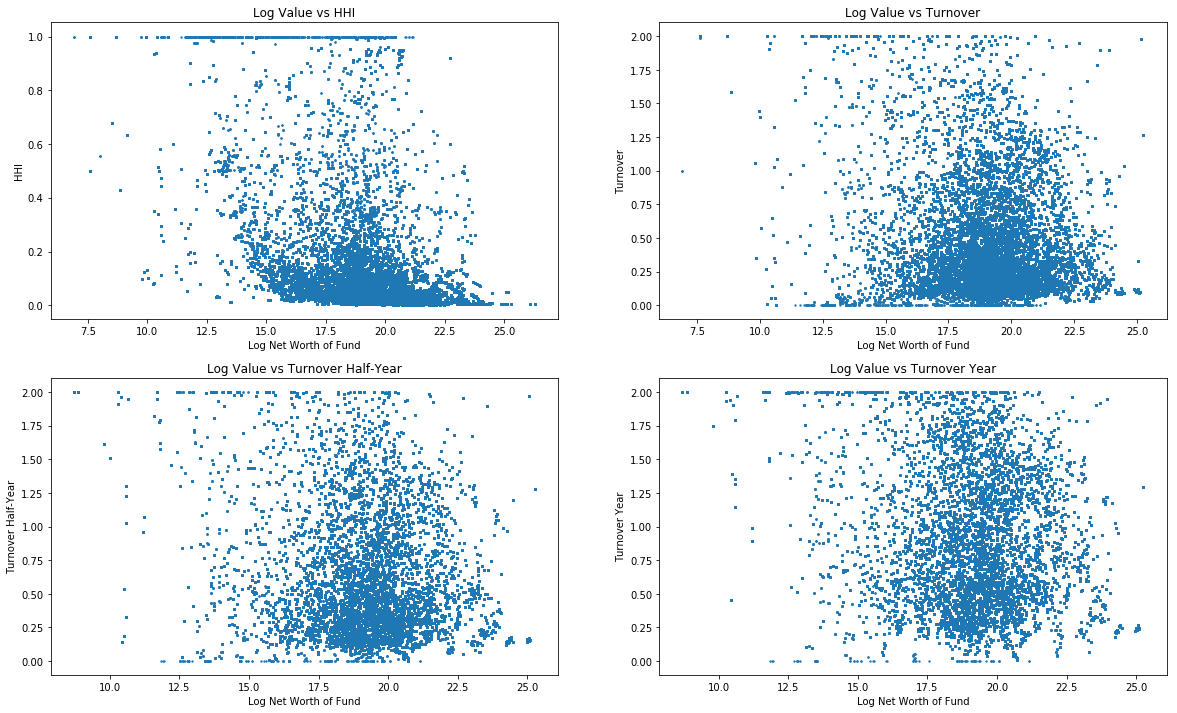

In [43] used 130.0078 MiB RAM in 89.64s, peaked 7.29 MiB above current, total RAM usage 2569.92 MiB


In [43]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Log Value vs HHI');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

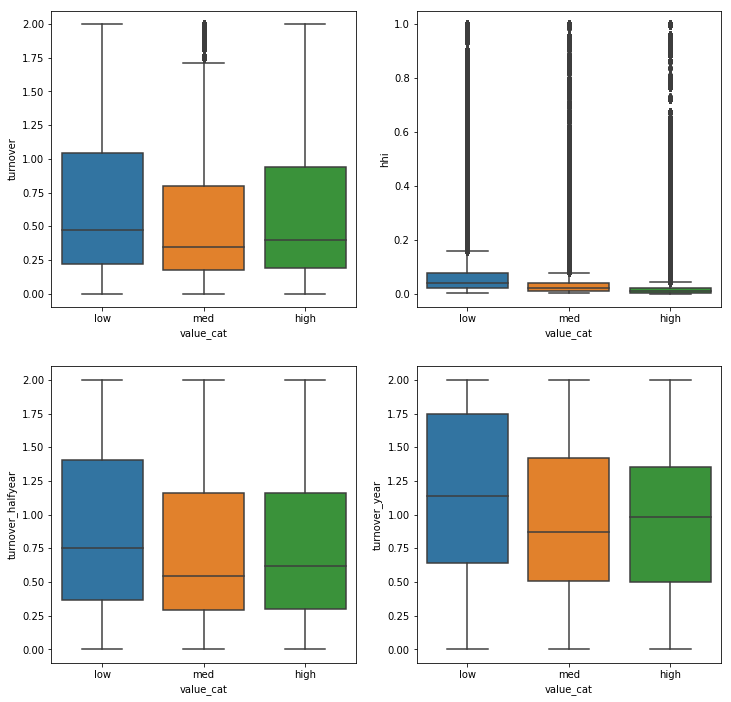

In [46] used 16.3789 MiB RAM in 5.56s, peaked 59.67 MiB above current, total RAM usage 1202.76 MiB


In [46]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

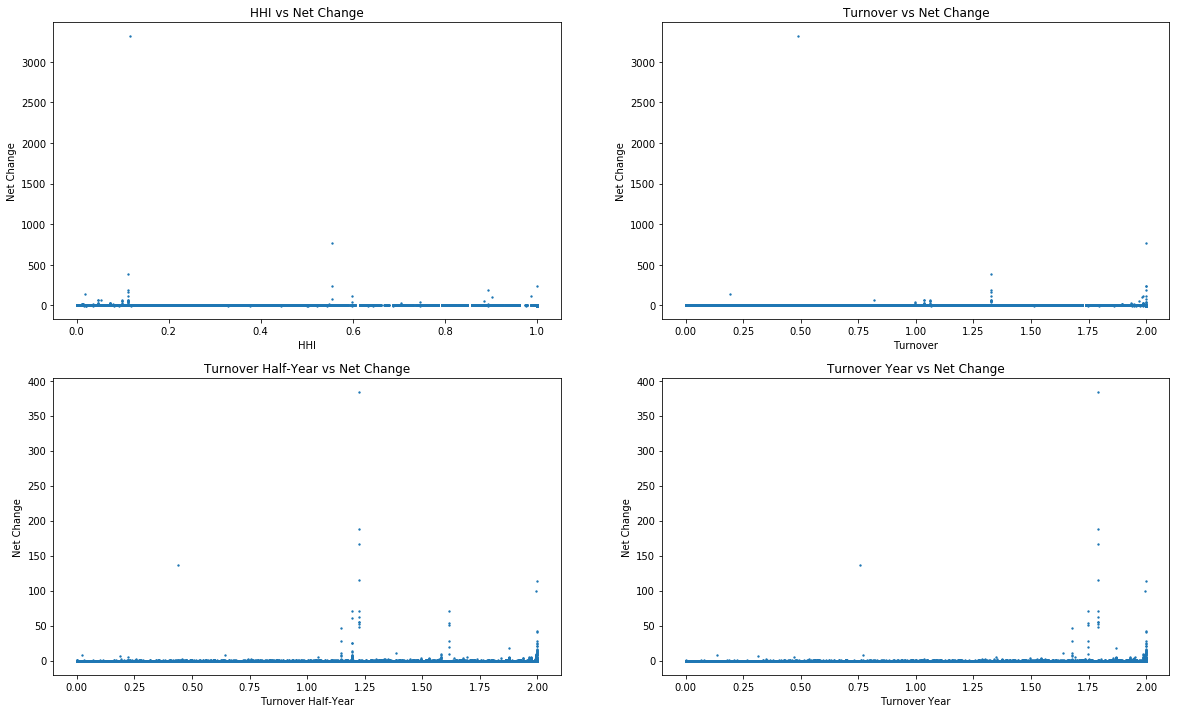

In [48] used 90.4609 MiB RAM in 90.92s, peaked 38.74 MiB above current, total RAM usage 378.68 MiB


In [48]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');

axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

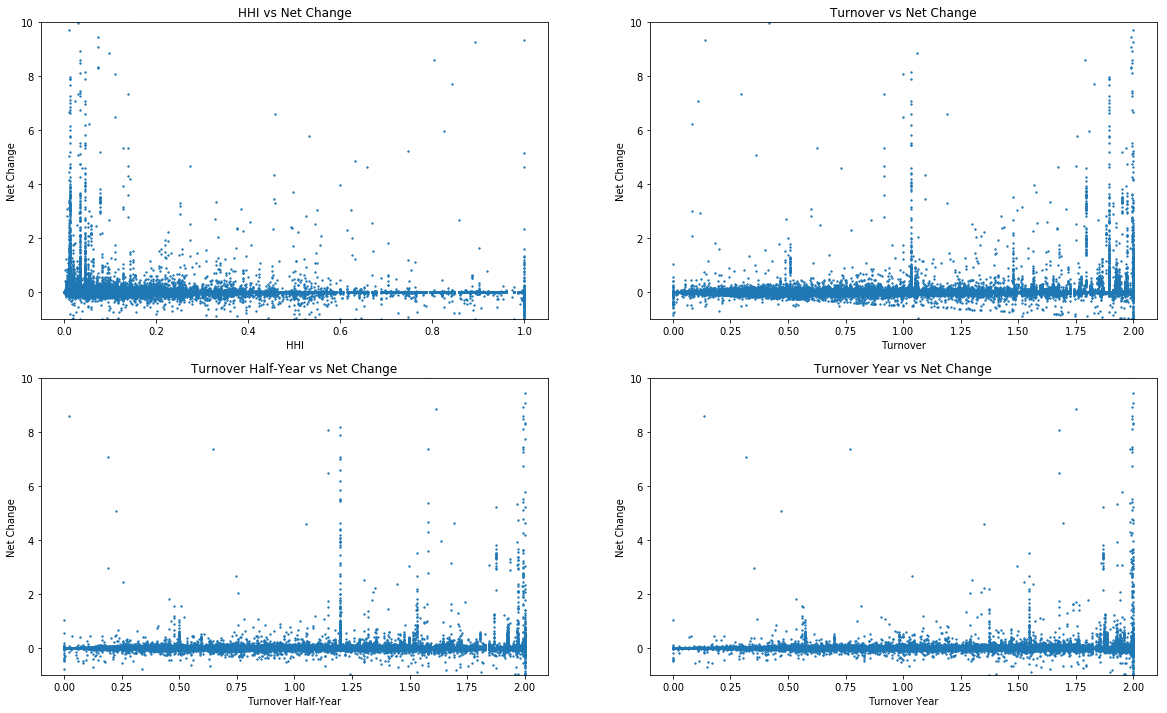

In [50] used 104.5039 MiB RAM in 104.05s, peaked 23.18 MiB above current, total RAM usage 558.98 MiB


In [50]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');
axs[0, 0].set_ylim(-1, 10);

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');
axs[0, 1].set_ylim(-1, 10);

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');
axs[1, 0].set_ylim(-1, 10);

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');
axs[1, 1].set_ylim(-1, 10);

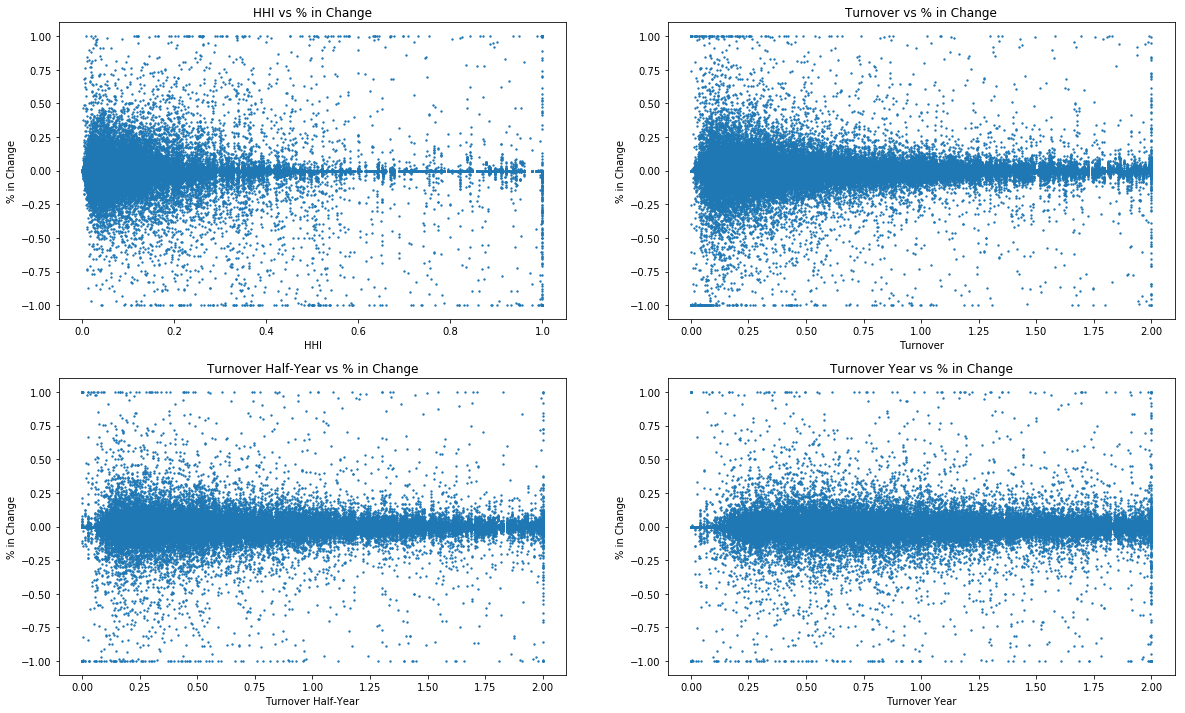

In [49] used 75.7969 MiB RAM in 93.35s, peaked 15.21 MiB above current, total RAM usage 454.47 MiB


In [49]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('HHI vs % in Change');
axs[0, 0].set(xlabel='HHI', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

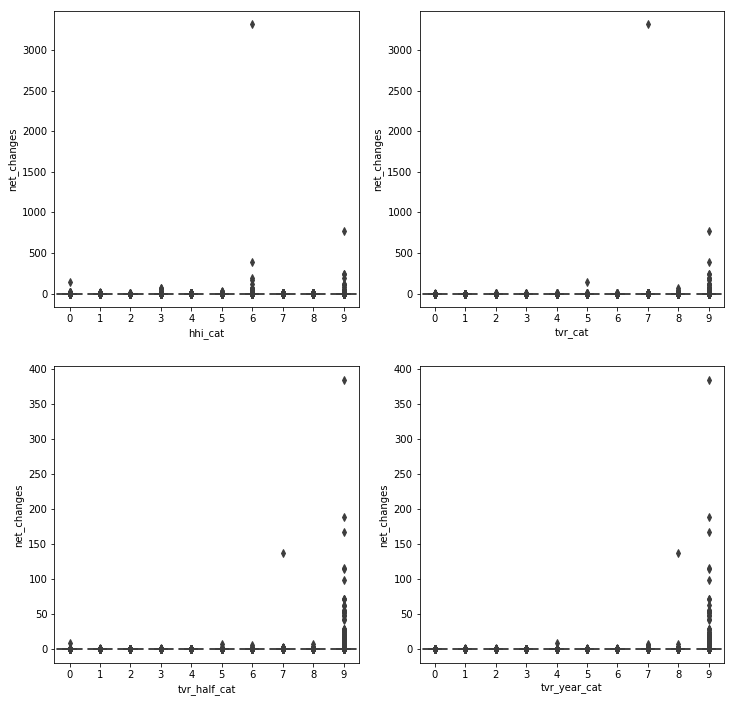

In [52] used 229.0234 MiB RAM in 18.95s, peaked 12.26 MiB above current, total RAM usage 790.27 MiB


In [52]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='net_changes', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='net_changes', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='net_changes', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='net_changes', data=final_df, ax=ax[1, 1]);

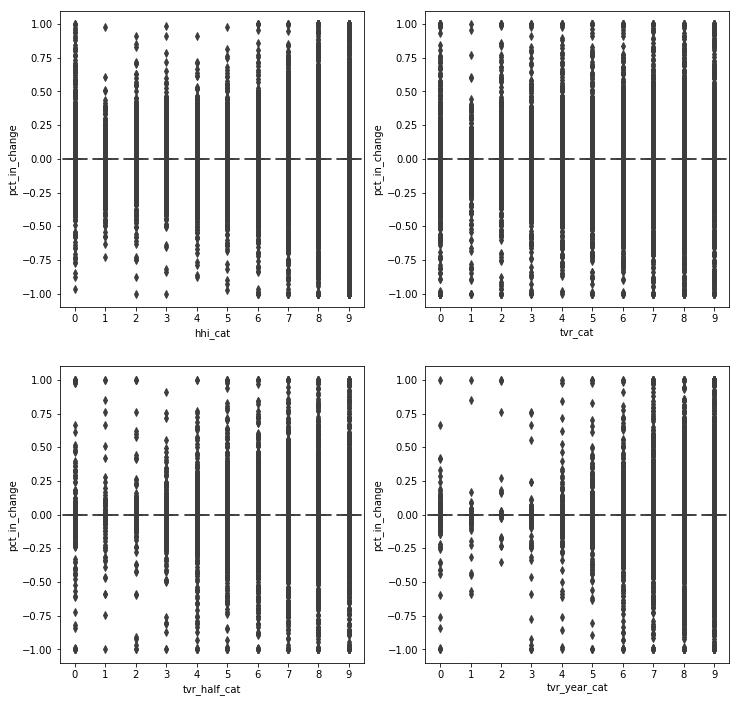

In [53] used -220.8320 MiB RAM in 17.70s, peaked 301.52 MiB above current, total RAM usage 569.44 MiB


In [53]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pct_in_change', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pct_in_change', data=final_df, ax=ax[1, 1]);

In [3]:
final_df = pd.read_pickle(r'final_df.pkl')

In [3] used 1360.9727 MiB RAM in 6.51s, peaked 178.11 MiB above current, total RAM usage 1481.22 MiB


<b> Я ОСТАНОВИЛСЯ ЗДЕСЬ!!!

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [4]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2016Q1,9631,1125
1,2016Q1,10742,146
2,2016Q1,14661,1695
3,2016Q1,35442,293
4,2016Q1,61227,994


In [4] used -752.9844 MiB RAM in 6.33s, peaked 979.45 MiB above current, total RAM usage 728.24 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [6]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [6] used 675.4727 MiB RAM in 14.93s, peaked 931.33 MiB above current, total RAM usage 1412.14 MiB


Теперь посмотрим на распределение количества позиций в фонде.

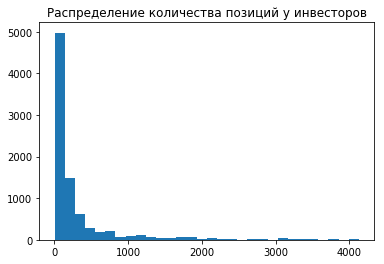

In [7] used 25.3047 MiB RAM in 1.09s, peaked 0.00 MiB above current, total RAM usage 1437.45 MiB


In [7]:
pl.hist(pos_count.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [8]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [0, 30, 200, 500, 1000, 2000, 3000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '2000-3000', '>3000'])

In [8] used 3.0938 MiB RAM in 0.26s, peaked 19.02 MiB above current, total RAM usage 1440.54 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

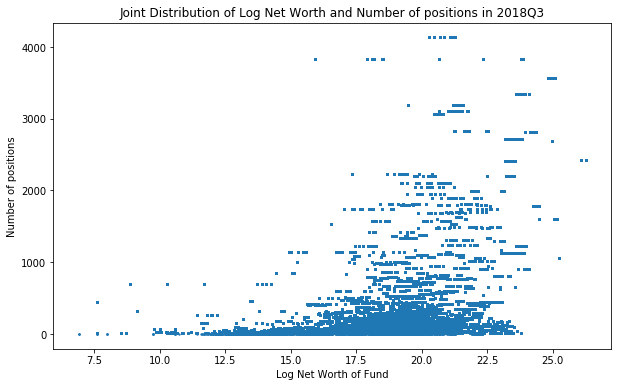

In [9] used 40.9688 MiB RAM in 27.73s, peaked 1.13 MiB above current, total RAM usage 1481.51 MiB


In [9]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

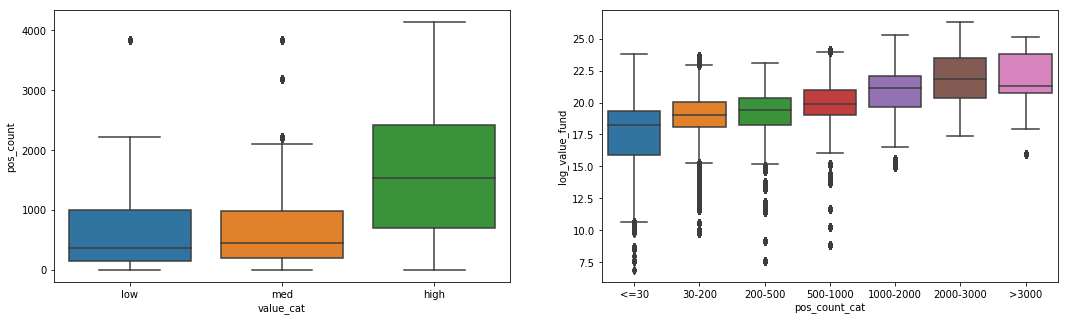

In [10] used 12.4258 MiB RAM in 2.26s, peaked 54.80 MiB above current, total RAM usage 1493.94 MiB


In [10]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

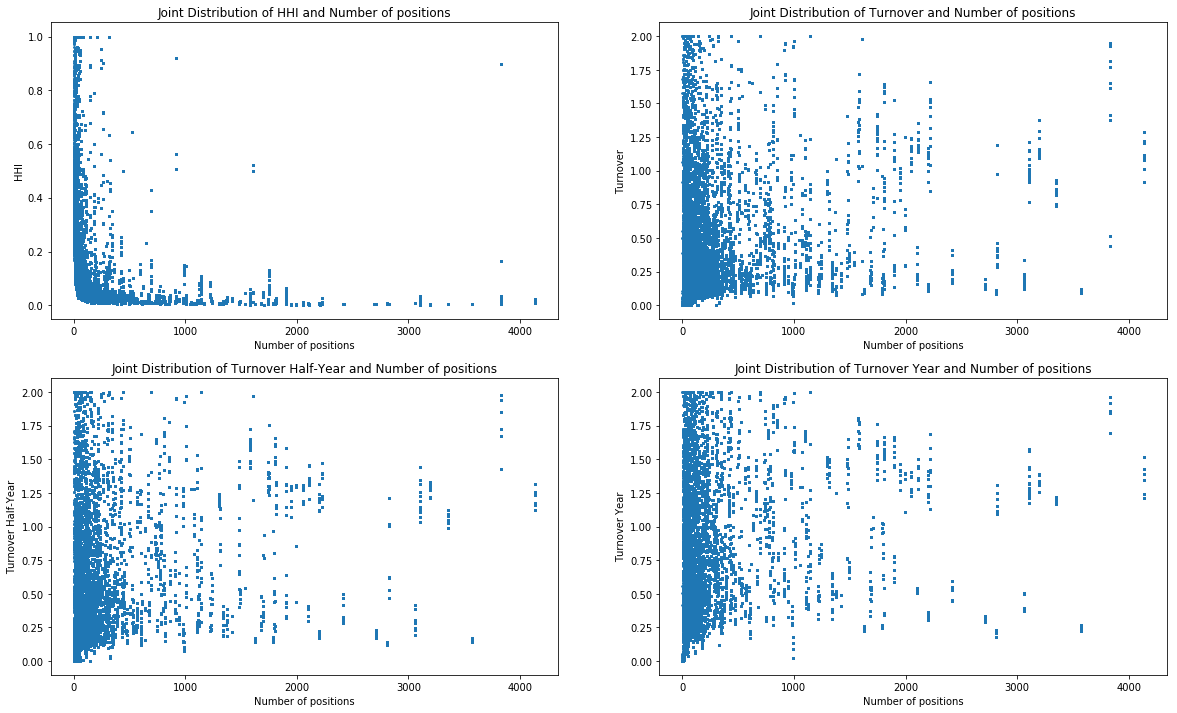

In [11] used 121.8438 MiB RAM in 105.02s, peaked 17.45 MiB above current, total RAM usage 1615.78 MiB


In [11]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Joint Distribution of HHI and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='HHI');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

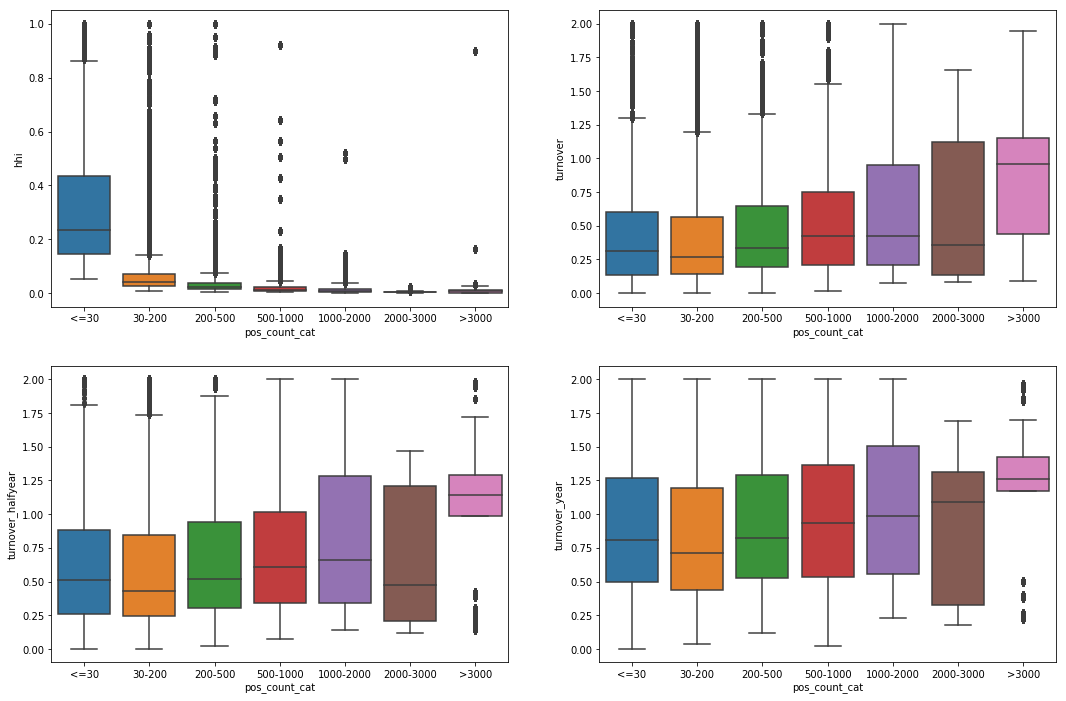

In [12] used 41.3320 MiB RAM in 6.60s, peaked 35.66 MiB above current, total RAM usage 1657.11 MiB


In [12]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

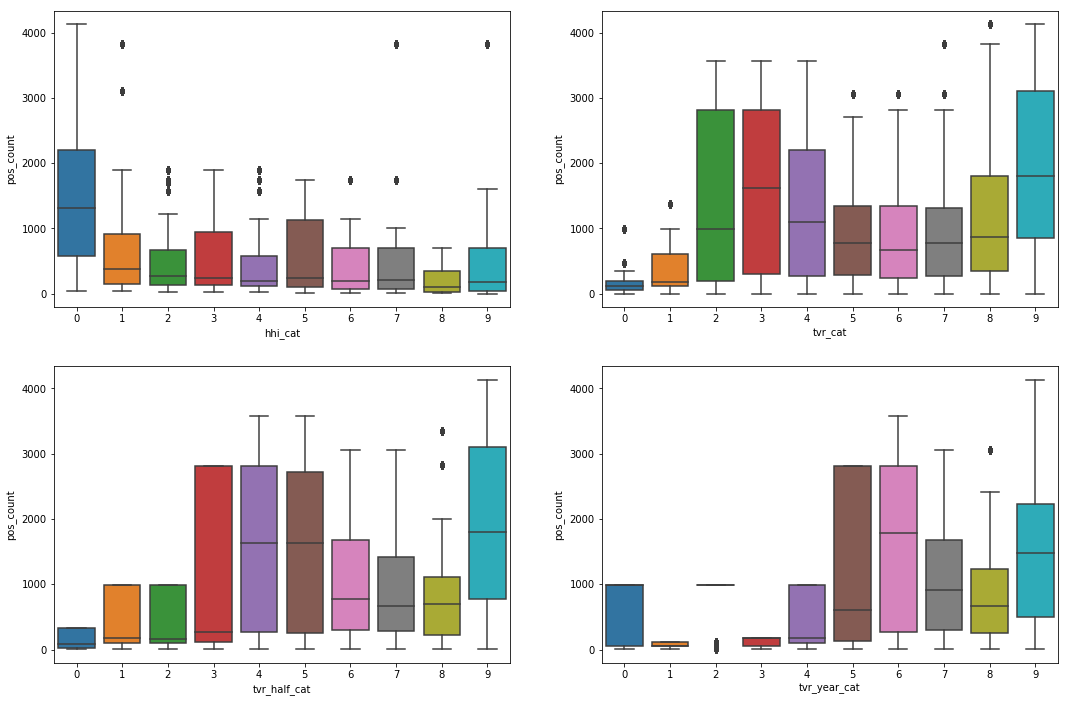

In [13] used 11.6836 MiB RAM in 3.01s, peaked 59.73 MiB above current, total RAM usage 1668.80 MiB


In [13]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

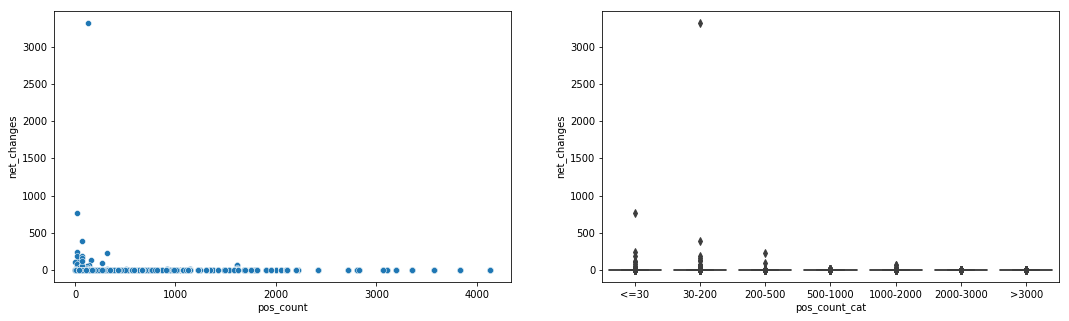

In [14] used 92.0195 MiB RAM in 34.03s, peaked 61.39 MiB above current, total RAM usage 1760.82 MiB


In [14]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

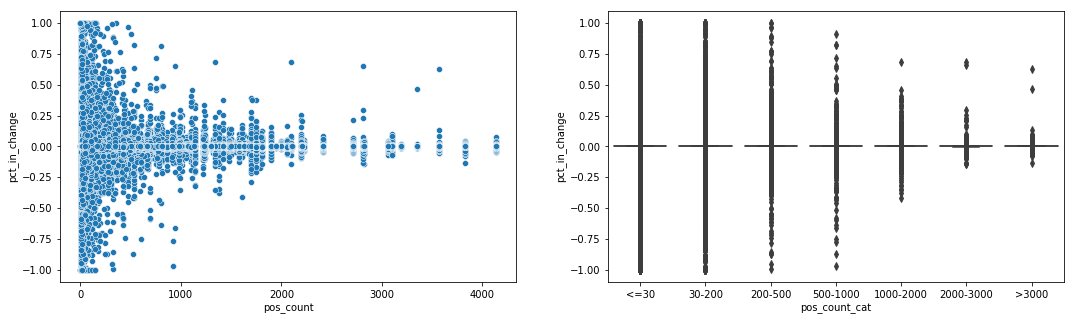

In [15] used 88.1641 MiB RAM in 35.13s, peaked 57.78 MiB above current, total RAM usage 1848.98 MiB


In [15]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [19]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,hhi,pos_count
log_value_fund,1.00,-0.06,-0.11,-0.15,-0.19,-0.50,0.53
net_changes_abs_sum,-0.06,1.00,0.95,0.89,0.82,-0.10,0.24
turnover,-0.11,0.95,1.00,0.93,0.85,-0.05,0.22
turnover_halfyear,-0.15,0.89,0.93,1.00,0.91,-0.00,0.19
turnover_year,-0.19,0.82,0.85,0.91,1.00,0.06,0.13
hhi,-0.50,-0.10,-0.05,-0.00,0.06,1.00,-0.66
pos_count,0.53,0.24,0.22,0.19,0.13,-0.66,1.00


In [19] used 5.9336 MiB RAM in 16.64s, peaked 538.21 MiB above current, total RAM usage 1070.95 MiB


Добавление средних изменений зависимых переменных.

In [20]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values

Wall time: 56.2 s
In [20] used 857.6445 MiB RAM in 56.28s, peaked 1747.43 MiB above current, total RAM usage 1928.60 MiB


In [54]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2016Q1,779,12452672.0,6.872135e+11,1.812053e-05
1,2016Q1,780,9676507.0,6.872135e+11,1.408079e-05
2,2016Q1,784,22696214.0,6.872135e+11,3.302644e-05
3,2016Q1,829,97784371.0,6.872135e+11,1.422911e-04
4,2016Q1,835,19800079.0,6.872135e+11,2.881212e-05
5,2016Q1,838,883000.0,6.872135e+11,1.284899e-06
6,2016Q1,850,5000.0,6.872135e+11,7.275760e-09
7,2016Q1,872,195027000.0,6.872135e+11,2.837939e-04
8,2016Q1,902,44636910.0,6.872135e+11,6.495348e-05
9,2016Q1,932,27277000.0,6.872135e+11,3.969218e-05


In [54] used 1313.7930 MiB RAM in 15.69s, peaked 1044.37 MiB above current, total RAM usage 1517.62 MiB


Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [66]:
import pandas_datareader as wb

In [66] used 12.3164 MiB RAM in 0.84s, peaked 0.00 MiB above current, total RAM usage 1163.85 MiB


In [67]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [67] used 12.3242 MiB RAM in 17.86s, peaked 4.90 MiB above current, total RAM usage 1176.17 MiB


In [68]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [68] used 0.2656 MiB RAM in 0.36s, peaked 0.00 MiB above current, total RAM usage 1176.44 MiB


In [69]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [69] used 0.1562 MiB RAM in 0.33s, peaked 0.00 MiB above current, total RAM usage 1176.59 MiB


In [70]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 12.5 s
In [70] used 537.8047 MiB RAM in 12.70s, peaked 1717.40 MiB above current, total RAM usage 1714.40 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [91]:
%%time

# final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp',
#               'mode_close', 'hhi_cat',  'tvr_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat'], axis=1, inplace=True)

# final_df = final_df.dropna(subset=['value_cat', 'net_changes', 'pct_in_change', 'turnover',
#                                    'turnover_halfyear', 'turnover_year']).fillna(0)

# final_df = final_df.dropna(subset=['net_changes', 'pct_in_change', 'turnover', 'turnover_halfyear', 'turnover_year']).fillna(0)

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

Wall time: 71.8 ms
In [91] used -1193.8633 MiB RAM in 0.20s, peaked 0.00 MiB above current, total RAM usage 1049.41 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [93]:
import statsmodels.api as sm

In [93] used 31.5742 MiB RAM in 3.19s, peaked 0.00 MiB above current, total RAM usage 1081.05 MiB


In [96]:
final_df.columns

Index(['cik', 'period', 'ticker_id', 'shares', 'market_value', 'close',
       '_object', 'market_value_fund', 'log_value_fund', 'quarter_sum',
       'object', 'market_value_fund_lag_1', 'diff_value_fund_lag_1',
       'diff_value_fund_rank_lag_1', 'market_value_fund_lag_2',
       'diff_value_fund_lag_2', 'diff_value_fund_rank_lag_2',
       'market_value_fund_lag_3', 'diff_value_fund_lag_3',
       'diff_value_fund_rank_lag_3', 'market_value_fund_lag_4',
       'diff_value_fund_lag_4', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'close_lag_1', 'shares_lag_1', 'net_changes', 'net_changes_abs_sum',
       'pct_in_change', 'pct_in_change_1', 'pct_in_change_2',
       'pct_in_change_3', 'pct_in_change_4', 'ticker_share_lag_1',
       'ticker_share_lag_4', 'ticker_share_lag_2', 'turnover',
       'turnover_halfyear', 'turnover_year', 'hhi', 'hhi_eq_1', 'pos_count',
       'pos_count_lag_1', 'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 

In [96] used 0.1016 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1614.68 MiB


In [119]:
data_common = final_df[~final_df.exit & ~final_df.enter]

In [119] used 1237.2695 MiB RAM in 4.14s, peaked 547.95 MiB above current, total RAM usage 2732.81 MiB


In [143]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share']].astype('float64')
X = sm.add_constant(X)

In [143] used 643.0938 MiB RAM in 4.33s, peaked 646.02 MiB above current, total RAM usage 2371.63 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [144]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1080.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:05:22   Log-Likelihood:             2.9744e+06
No. Observations:             1144766   AIC:                        -5.949e+06
Df Residuals:                 1144740   BIC:                        -5.948e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0006      0.000      1.818      0.069   -4.46e-05       0.001
log_value_fund               -6.22e-05   1.49e-05     -4.171      0.000   -9.14e-05    -3.3e-05
diff_value_fund_rank_lag_1      0.0012   6.66e-05     18.119      0.000       0.001       0.001
diff_value_fund_rank_lag_2   5.204e-05   6.43e-05      0.809      0.418    -7.4e-05       0.000
diff_value_fund_rank_lag_3   7.029e-05   6.48e-05      1.084      0.278   -5.67e-05       0.000
diff_value_fund_rank_lag_4   5.427e-06   6.91e-05      0.079      0.937      -0.000       0.000
ticker_share                   -0.0696      0.010     -6.793      0.000      -0.090      -0.050
pct_in_change_1                 0.0821      0.001    118.342      0.000       0.081       0.083
pct_in_change_2                 0.0359      0.001     53.304      0.000       0.035       0.037
pct_in_change_3                 0.0199      0.001     29.465      0.000       0.019       0.021
pct_in_change_4                 0.0167      0.001     22.596      0.000       0.015       0.018
turnover                     4.891e-05   9.56e-05      0.511      0.609      -0.000       0.000
turnover_halfyear           -7.443e-05      0.000     -0.691      0.490      -0.000       0.000
turnover_year                   0.0002   7.76e-05      2.347      0.019       3e-05       0.000
hhi                            -0.0012      0.000     -5.550      0.000      -0.002      -0.001
hhi_eq_1                        0.0094      0.001     16.051      0.000       0.008       0.011
pos_count                    -5.34e-08   2.08e-08     -2.561      0.010   -9.43e-08   -1.25e-08
mean_pct_in_change              0.0570      0.005     12.196      0.000       0.048       0.066
mean_pct_in_change_by_cik       0.1655      0.003     63.742      0.000       0.160       0.171
mean_pct_in_change_by_value     0.0150      0.003      5.106      0.000       0.009       0.021
tickers_count               -1.264e-08    5.8e-07     -0.022      0.983   -1.15e-06    1.12e-06
tickers_count_by_value      -4.915e-07   1.29e-06     -0.380      0.704   -3.02e-06    2.04e-06
log_market_value_ticker     -5.925e-13   9.34e-14     -6.343      0.000   -7.76e-13   -4.09e-13
ticker_market_share             0.5543      0.091      6.062      0.000       0.375       0.734
bench_dev                       0.0664      0.021      3.203      0.001       0.026       0.107
active_share                    0.0002      0.000      0.908      0.364      -0.000       0.001
==============================================================================
Omnibus:                  1112320.761   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      89923641542.116
Skew:                          -2.865   Prob(JB):             

In [144] used -616.7656 MiB RAM in 4.95s, peaked 1306.80 MiB above current, total RAM usage 1754.86 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [104]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

In [104] used 8.8359 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 2592.26 MiB


Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

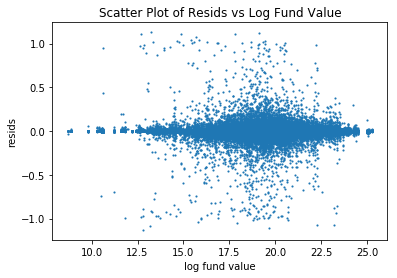

In [105] used 25.7031 MiB RAM in 8.23s, peaked 0.00 MiB above current, total RAM usage 2617.96 MiB


In [105]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

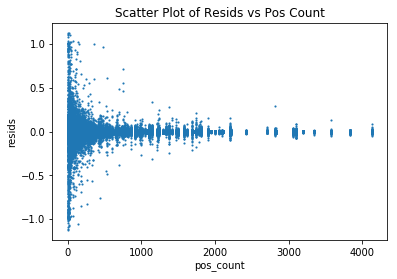

In [106] used 18.8945 MiB RAM in 7.93s, peaked 0.00 MiB above current, total RAM usage 2636.86 MiB


In [106]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

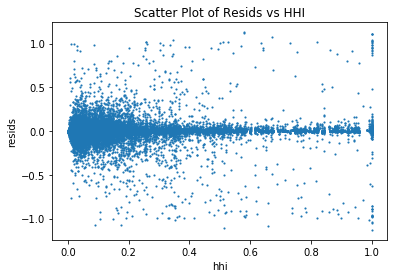

In [107] used 18.8359 MiB RAM in 7.95s, peaked 0.00 MiB above current, total RAM usage 2655.69 MiB


In [107]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

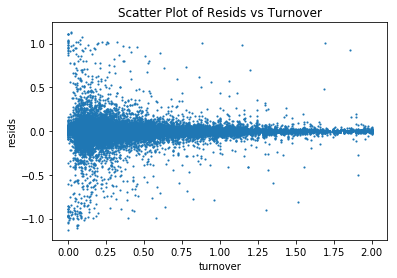

In [108] used 18.6016 MiB RAM in 8.90s, peaked 0.96 MiB above current, total RAM usage 2674.29 MiB


In [108]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

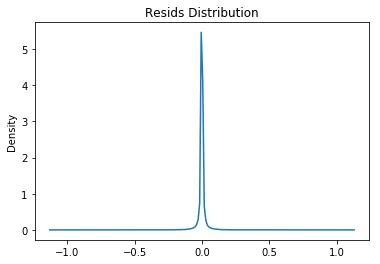

In [109] used 2.6992 MiB RAM in 18.09s, peaked 103.52 MiB above current, total RAM usage 2676.99 MiB


In [109]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [145]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [145] used 219.6641 MiB RAM in 1.33s, peaked 768.59 MiB above current, total RAM usage 1974.53 MiB


In [146]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     901.6
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:06:08   Log-Likelihood:             2.9744e+06
No. Observations:             1144766   AIC:                        -5.949e+06
Df Residuals:                 1144735   BIC:                        -5.948e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0024      0.001      4.747      0.000       0.001       0.003
log_value_fund              -6.583e-05   1.49e-05     -4.410      0.000   -9.51e-05   -3.66e-05
diff_value_fund_rank_lag_1      0.0013   6.84e-05     19.149      0.000       0.001       0.001
diff_value_fund_rank_lag_2   2.058e-05   6.59e-05      0.312      0.755      -0.000       0.000
diff_value_fund_rank_lag_3   2.929e-05   6.56e-05      0.447      0.655   -9.93e-05       0.000
diff_value_fund_rank_lag_4   2.766e-05   6.94e-05      0.398      0.690      -0.000       0.000
ticker_share                   -0.0697      0.010     -6.795      0.000      -0.090      -0.050
pct_in_change_1                 0.0821      0.001    118.335      0.000       0.081       0.083
pct_in_change_2                 0.0359      0.001     53.326      0.000       0.035       0.037
pct_in_change_3                 0.0199      0.001     29.450      0.000       0.019       0.021
pct_in_change_4                 0.0167      0.001     22.597      0.000       0.015       0.018
turnover                     4.558e-05   9.57e-05      0.476      0.634      -0.000       0.000
turnover_halfyear           -7.916e-05      0.000     -0.734      0.463      -0.000       0.000
turnover_year                   0.0002   7.77e-05      2.449      0.014     3.8e-05       0.000
hhi                            -0.0013      0.000     -5.881      0.000      -0.002      -0.001
hhi_eq_1                        0.0095      0.001     16.183      0.000       0.008       0.011
pos_count                   -5.425e-08   2.09e-08     -2.601      0.009   -9.51e-08   -1.34e-08
mean_pct_in_change              0.0569      0.005     12.166      0.000       0.048       0.066
mean_pct_in_change_by_cik       0.1649      0.003     63.511      0.000       0.160       0.170
mean_pct_in_change_by_value     0.0150      0.003      5.098      0.000       0.009       0.021
tickers_count               -2.254e-08   5.81e-07     -0.039      0.969   -1.16e-06    1.12e-06
tickers_count_by_value      -4.185e-07   1.29e-06     -0.323      0.746   -2.95e-06    2.12e-06
log_market_value_ticker     -5.205e-13   1.02e-13     -5.116      0.000    -7.2e-13   -3.21e-13
ticker_market_share             0.4843      0.099      4.871      0.000       0.289       0.679
bench_dev                       0.0665      0.021      3.207      0.001       0.026       0.107
active_share                    0.0002      0.000      0.978      0.328      -0.000       0.001
DGS10                           0.2069      0.042      4.914      0.000       0.124       0.289
DFF                            -0.2039      0.062     -3.312      0.001      -0.325      -0.083
UNRATE                          0.2605      0.050      5.180      0.000       0.162       0.359
CPIAUCSL   

In [146] used 181.1914 MiB RAM in 5.54s, peaked 640.15 MiB above current, total RAM usage 2155.72 MiB


(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 3

In [147]:
y = data_common['net_changes']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [147] used 253.5117 MiB RAM in 1.05s, peaked 563.18 MiB above current, total RAM usage 2409.23 MiB


In [148]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.071
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           2.61e-06
Time:                        02:06:43   Log-Likelihood:             6.3069e+05
No. Observations:             1144766   AIC:                        -1.261e+06
Df Residuals:                 1144744   BIC:                        -1.261e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0016      0.003      0.556      0.578      -0.004       0.007
log_value_fund             -4.377e-05      0.000     -0.379      0.705      -0.000       0.000
diff_value_fund_rank_lag_1     0.0007      0.001      1.383      0.167      -0.000       0.002
diff_value_fund_rank_lag_2     0.0009      0.001      1.757      0.079      -0.000       0.002
diff_value_fund_rank_lag_3     0.0004      0.001      0.799      0.425      -0.001       0.001
diff_value_fund_rank_lag_4    -0.0002      0.001     -0.391      0.696      -0.001       0.001
ticker_share                   0.0294      0.006      5.036      0.000       0.018       0.041
net_changes_1               6.217e-05      0.001      0.087      0.930      -0.001       0.001
net_changes_2                 -0.0004      0.001     -0.594      0.553      -0.002       0.001
net_changes_3                 -0.0004      0.001     -0.622      0.534      -0.002       0.001
net_changes_4                 -0.0006      0.001     -0.770      0.441      -0.002       0.001
turnover                       0.0008      0.001      1.101      0.271      -0.001       0.002
turnover_halfyear             -0.0005      0.001     -0.629      0.530      -0.002       0.001
turnover_year                  0.0009      0.001      1.465      0.143      -0.000       0.002
hhi                           -0.0013      0.002     -0.788      0.430      -0.005       0.002
hhi_eq_1                      -0.0045      0.005     -0.989      0.323      -0.013       0.004
pos_count                  -2.884e-07   1.61e-07     -1.786      0.074   -6.05e-07    2.81e-08
tickers_count              -2.484e-06   4.49e-06     -0.553      0.580   -1.13e-05    6.32e-06
tickers_count_by_value     -3.914e-06      1e-05     -0.391      0.696   -2.36e-05    1.57e-05
log_market_value_ticker      2.18e-13   1.11e-13      1.956      0.050   -4.64e-16    4.36e-13
tickers_total_value         3.646e-16   1.71e-15      0.214      0.831   -2.98e-15    3.71e-15
ticker_market_share            0.0025      0.008      0.310      0.756      -0.014       0.019
bench_dev                      0.0120      0.007      1.771      0.076      -0.001       0.025
active_share                  -0.0025      0.002     -1.630      0.103      -0.006       0.001
DGS10                         -0.0186      0.022     -0.853      0.393      -0.061       0.024
DFF                            0.0290      0.093      0.313      0.754      -0.153       0.211
UNRATE                        -0.0045      0.003     -1.582      0.114      -0.010       0.001
CPIAUCSL                      -0.0286      0.019     -1.541      0.123      -0.065       0.008
GDP                           -0.0442      0.028     -1.599      0.110      -0.098       0.010
===========================================

In [148] used 64.6328 MiB RAM in 5.01s, peaked 704.05 MiB above current, total RAM usage 2473.86 MiB


### Модель 4

In [137]:
y = data_common['enter']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'tickers_count',
       'tickers_count_by_value', 'market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share', 'log_tickers_total_value',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [137] used 218.4141 MiB RAM in 1.03s, peaked 607.64 MiB above current, total RAM usage 2209.88 MiB


In [138]:
model_4 = sm.Logit(y, X).fit()
model_4.summary()

PerfectSeparationError: Perfect separation detected, results not available

In [138] used 8.7930 MiB RAM in 12.14s, peaked 289.78 MiB above current, total RAM usage 2218.67 MiB


# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [54]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

In [54] used 1418.7266 MiB RAM in 52.11s, peaked 963.24 MiB above current, total RAM usage 1988.16 MiB


# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...